In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model


from util import config
from util import get_data
from util import clean_data
from util import process_data

## Get insight on the feature importances for difficulty

This dataset is unlabelled, so it is harder to make inferences about which features are significant to ride difficulty.  For example, I could (a) work with domain knowledge to prescribe these a priori; (b) perform some clustering analysis to try and get a sense for which features tend to go with each other in this particular dataset; (c) hand label some examples and try to infer from a smaller, labelled dataset.

Option (a) is challenging because it is very hard to have real confidence in.  Option (b) would really just inform options (a) or (c).  Option (c) is suboptimal because I have not been on more than a handful of these rides, so I don't even have a (highly subjective!) opinion about how difficult they are.

Fortunately, there are some hand-labels that I can use! The local guide book, "Backroad Bicycling in the Hudson Valley and Catskills" by Peter Kick and Dori O'Connell, rates each of their suggested rides as 'Easy', 'Moderate', or 'Strenuous'.  I have loaded all of these rides into RideWithGPS, so I can download and process the data in a similar way.  I then perform a logistic regression to try to identify important features.

## Load and process book data

In [3]:
# These are the ride IDs, used to locate the rides in the RideWithGPS API
book_ids = {
    'easy': [34334830, 34334875, 34334946, 34334973, 34334993, 
             34335057, 34335164, 34335190, 34335257],
    'moderate': [34334760, 34334840, 34334850, 34334931, 34335019,
                  34335063, 34335072, 34335087, 34335143, 34335210,
                  34335223, 34335265, 34335284, 34335362, 34335395],
    'strenuous': [34334791, 34334812, 34334864, 34334890, 
               34334909, 34334917, 34334959, 34335041,
               34335104, 34335111, 34335122, 34335154,
               34335236, 34335379],
}

Download, clean, and save all of the book routes.

Note that these routes still need cleaning as there are imperfections, e.g. in the DEM (digital elevation model), such that features like the slope can return crazy values.  The cleaning step also renames columns, and calculates some additional features (e.g. slope from elevation).

It also calculates e.g. speed using time information, which I just fill here with a dummy value so it doesn't throw an error.

In [4]:
# Note: Do not rerun this cell casually - it downloads data!
for rte_id in [i for v in book_ids.values() for i in v]:
    print(rte_id)
    rte_df = get_data.ridewithgps_api_ride(rte_id, 'routes', False)
    
    rte_df['t'] = 0 # Need to add this column for clean_data.clean_single_trip()
    rte_df = clean_data.clean_single_trip(rte_df)
    rte_df['rte_id'] = rte_id
    config.save_df(rte_df, config.CLEAN_TRIPS_PATH,
                   'route_{}.feather'.format(rte_id))

34334830
34334875
34334946
34334973
34334993
34335057
34335164
34335190
34335257
34334760
34334840
34334850
34334931
34335019
34335063
34335072
34335087
34335143
34335210
34335223
34335265
34335284
34335362
34335395
34334791
34334812
34334864
34334890
34334909
34334917
34334959
34335041
34335104
34335111
34335122
34335154
34335236
34335379


In [5]:
# Generate ride difficulty features, as with real data
book_routes_orig = process_data.get_features_from_rte_files(
    ['route_{}'.format(rte_id) for v in book_ids.values() for rte_id in v]
)
book_routes_orig = book_routes_orig.set_index('rte_id').fillna(0)


0


What we are ultimately interested in:

* Which features are significant?
* How should significant features be weighted with respect to each other in the nearest-neighbours algorithm?

For the first point, I am going to use LASSO regression.  This also helps to deal with the multicollinearity problem identified when doing Feature Engineering (<i>03-Feature-Engineering.ipynb</i>).

As to the second, feature weights are much more useful in this context from a binary classification.  I don't want to classify each ride as 'Easy', 'Moderate', or 'Strenuous' (as my labelled data set is too small).  Instead, I want to use the feature weights to guide the relative weighting.  With multiclass classification, there is more than one decision boundary, so it is not as straightforward to use in this context.

Other good reasons to use a binary classification:

* There are relatively few 'easy' rides, so I can rebalance my classes by merging 'easy/moderate' and comparing to 'strenuous'
* The dataset is very small, so even a binary classification is somewhat ambitious!


In [6]:
s_ids = ['route_{}'.format(v) for v in book_ids['strenuous']]

book_routes_orig['rating'] = 'easy'
book_routes_orig.loc[s_ids, 'rating'] = 'hard'

#### EDA

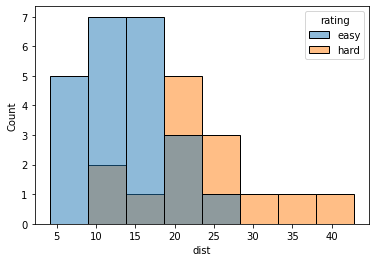

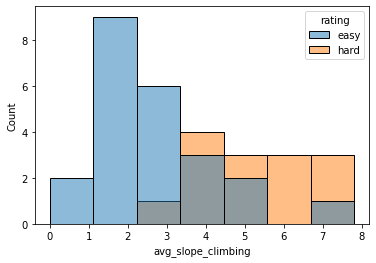

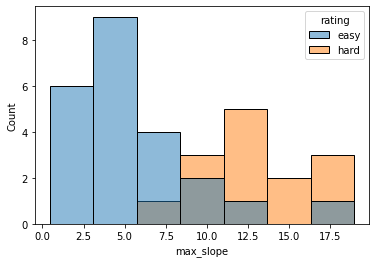

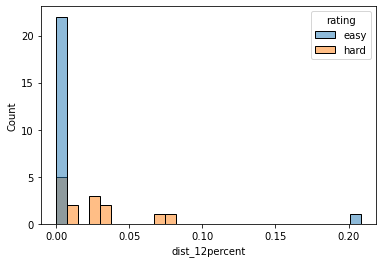

In [7]:
colours = sns.color_palette('husl', 3)

for col in ['dist', 'avg_slope_climbing', 'max_slope', 'dist_12percent']:
    if col == 'rating': continue
    plt.figure()
    sns.histplot(book_routes_orig, x=col, hue='rating')

Most of these plots show a relatively clear distinction between the 'easy' and 'hard' routes - so this should be an ok decision boundary.  It is also good that, in general, the 'easy' rides have lower values of these features that I intuited should increase with ride difficulty!  That is, the calculated values make sense.

However, we can see there is clearly a problem with one of the 'easy' rides - it should definitely not be going above 12% slope for over 1/5 of the ride!

In [8]:
book_routes_orig[book_routes_orig.dist_12percent > 0.15]

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,rating
rte_id,,,,,,,,,,
route_34334973,6.71499,7.299312,-1.555338,17.407868,0.609237,0.0,0.311218,0.311218,0.208228,easy


When plotting the data, there are clearly some errors in the slope data, and because I have smoothed the slope, these persist!  This ride is unusable.

Text(0.5, 1.0, 'Bad route: 34334973')

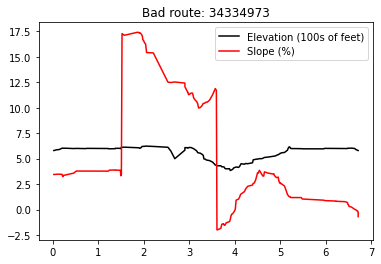

In [9]:
bad_rte = pd.read_feather(os.path.join(config.CLEAN_TRIPS_PATH,
                      'route_{}.feather'.format(34334973)))
plt.plot(np.cumsum(bad_rte.dist), bad_rte.elevation/100, 'k-', label='Elevation (100s of feet)')
plt.plot(np.cumsum(bad_rte.dist), bad_rte.slope, 'r-', label='Slope (%)')
plt.legend()
plt.title('Bad route: 34334973')

Drop this route!

In [13]:
book_routes_orig.drop('route_34334973', inplace=True)

(36, 10)

#### Normalise and scale the data
Now scale the book data like the real data.

Note that because we are using the scaling from the data, this data is not actually centred.  For example, these rides are on average shorter and slightly less steep than the rides in the database.

In [16]:
# And scale it etc in the same way as the real data
book_routes = process_data.engineer_normal_features(book_routes_orig)
# Add detour_score and popularity columns for scaling 
book_routes['detour_score'] = 0
book_routes['popularity'] = 0
book_routes = process_data.apply_scaling(book_routes)
book_routes.describe()

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,detour_score,popularity
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,-1.088324,-0.340648,-0.558050,-1.011501,0.025928,0.662632,-0.283435,0.021410,0.129208,-5.394382,-1.861661
std,0.777217,1.410609,1.847069,1.099016,1.439485,1.577466,1.599176,1.539928,1.432388,0.000000,0.000000
min,-3.237620,-2.939289,-6.264180,-2.639519,-1.812463,-1.447344,-1.888246,-1.057159,-0.638736,-5.394382,-1.861661
25%,-1.447504,-1.450037,-1.429615,-1.974955,-1.515093,-0.729509,-1.888246,-1.057159,-0.638736,-5.394382,-1.861661
50%,-1.096480,-0.484817,-0.311908,-1.147016,0.248102,0.529414,-0.268509,-1.057159,-0.638736,-5.394382,-1.861661
75%,-0.630093,0.645788,0.658441,-0.126908,1.120487,1.568398,1.376340,1.368343,-0.193559,-5.394382,-1.861661
max,0.455164,2.763639,2.751023,1.313350,3.753821,3.999507,2.627545,3.609013,4.097330,-5.394382,-1.861661


## Build a classifier

Here, I am just going to use a simple logistic regression to predict classes - 'easy', 'hard'.  This should be fine as our EDA showed the data was relatively separable, with low values for most of these difficulty features corresponding to easy rides. 

In [114]:
data = book_routes.copy().reset_index()
data.drop(['rte_id', 'rating', 'detour_score', 'popularity'], axis=1, inplace=True)
target = book_routes_orig.rating == 'hard'
target = target.astype('int')

X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(data, target)#, random_state=42)
)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
print(y_train.shape, y_test.shape)

(27,) (9,)


#### Identify significant features
First, train using LASSO regularisation to try and identify the features that are most significant.  This is useful because
 - removing features helps reduce the amount of colinearity in the calculated features
 - the user will be inputting values for each of these features in the evenutal app
     - even if using all of these features helped with the quality of the predictions, it is not very user friendly to have to put in over a dozen values as an app user
     - the alternative to the user putting in values themselves is to set default values, but this can lead to counter-intuitive results where the hidden default values control the returned nearest neighbours more than the user's set values

In [122]:
clf = sklearn.linear_model.LogisticRegression(
    penalty='l1', solver='liblinear')
cols = X_train.columns.tolist()

There is so little data, I'm going to use LOO to cross validate.

In [124]:
loo = sklearn.model_selection.LeaveOneOut()
feature_coefs = pd.DataFrame(index=cols)
i = 0
for train_index, valid_index in loo.split(X_train):
    X_train1, X_valid = X_train.loc[train_index], X_train.loc[valid_index]
    y_train1, y_valid = y_train.loc[train_index], y_train.loc[valid_index]

    clf.fit(X_train1[cols], y_train1)
    if clf.predict(X_valid)[0] == y_valid.values[0]:
        feature_coefs['coef_{}'.format(i)] = clf.coef_.flatten()
        i += 1

print('{} of {} validation set predicted correctly'.format(i, loo.get_n_splits(X_train)))
feature_coefs['avg_coef'] = np.mean(feature_coefs.values, axis=1)
feature_coefs['absvals'] = abs(feature_coefs.avg_coef)
feature_coefs.sort_values('absvals', ascending=False)[['avg_coef']]

26 of 27 validation set predicted correctly


,avg_coef
avg_slope_descending,-1.998386
dist,0.865058
dist_6percent,0.181211
dist_12percent,0.114386
max_slope,0.001128
avg_slope_climbing,0.000000
dist_climbing,0.000000
dist_downhill,0.000000
dist_9percent,0.000000


#### Pick the features

From this regression, we have found a list of the likely best features to use. 

In [177]:
cols = ['dist', 'dist_6percent', 'dist_12percent', 'max_slope', 'avg_slope_descending']


Check for colinearity

<AxesSubplot:>

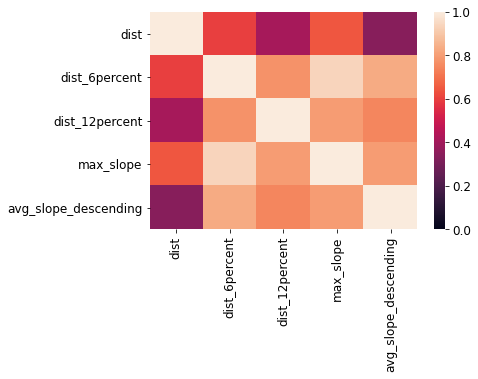

In [175]:
df_corr = X_train[cols].copy()
df_corr['avg_slope_descending'] *= -1
sns.heatmap(df_corr.corr(), vmin=0, vmax=1)

So everything is still pretty highly correlated...  The features that are least correlated with each other are
- distance
- avg_slope_descending
- dist_12_percent

dist_6_percent and max_slope are very highly correlated, and I think max_slope is easier for the user to understand as an input.

Also from a UX perspective, average slope when descending is pretty counter-intuitive.  Perhaps I can just swap in average slope when ascending?  Most of these routes are loops, so they should be very highly correlated.

<AxesSubplot:>

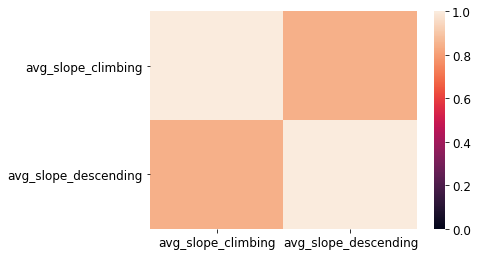

In [178]:
df_corr = X_train[['avg_slope_climbing', 'avg_slope_descending']].copy()
df_corr['avg_slope_descending'] *= -1
sns.heatmap(df_corr.corr(),  vmin=0, vmax=1)

Yep!  Very highly correlated, so I'll use avg_slope_climbing.

In [179]:
cols = ['dist', 'dist_12percent', 'max_slope', 'avg_slope_climbing']

/home/emily/anaconda3/envs/insight/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


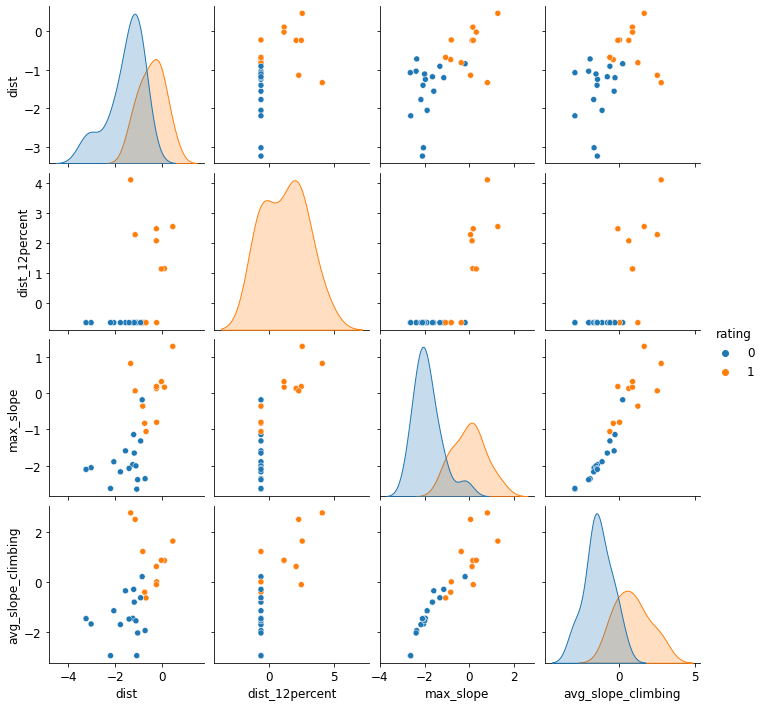

In [180]:
sns.pairplot(data=X_train[cols].join(y_train), hue='rating')

#### Ride Regression

Get the final coefficients with Ridge Regression.

In [233]:
clf = sklearn.linear_model.LogisticRegression()


clf.fit(X_train[cols], y_train)
feature_coef = pd.DataFrame({'coefficient': clf.coef_.flatten()}, 
                             index=cols)

feature_coef


,coefficient
dist,1.019621
dist_12percent,0.503401
max_slope,0.785655
avg_slope_climbing,0.802647


Text(0.5, 1.0, 'Training Data')

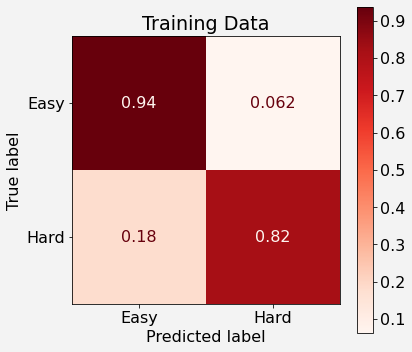

In [269]:
f, ax = plt.subplots(figsize=(6, 6))
sklearn.metrics.plot_confusion_matrix(clf, X_train[cols], y_train,
                                 display_labels=['Easy', 'Hard'],
                                 cmap=plt.cm.Reds,
                                 normalize='true', ax=ax);
plt.title('Training Data')

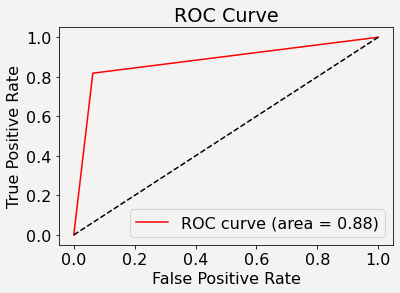

In [268]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = sklearn.metrics.roc_curve(y_train, clf.predict(X_train[cols]))
roc_auc = sklearn.metrics.auc(fpr, tpr)

f, ax = plt.subplots()
ax.plot(fpr, tpr, 'r-', label='ROC curve (area = {:0.2f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()


Text(0.5, 1.0, 'Test Data')

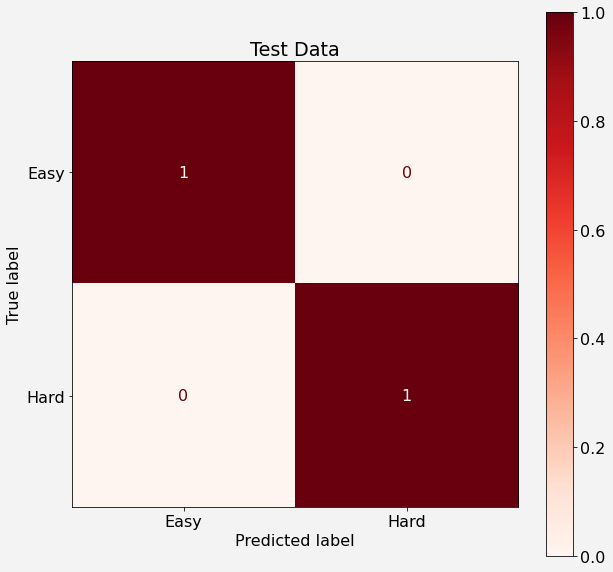

In [267]:
plt.rcParams['axes.facecolor'] = '#F3F3F3'
plt.rcParams['figure.facecolor'] = '#F3F3F3'
plt.rcParams['font.size'] = 16
f, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(clf, X_test[cols], y_test,
                                 display_labels=['Easy', 'Hard'],
                                 cmap=plt.cm.Reds,
                                 normalize='true', ax=ax)
plt.title('Test Data')

Ok, this seems promising!  Maybe a little too clean, though. Let's take a closer look at the prediction probabilities.

In [238]:
df = pd.DataFrame({'Rating': y_test, 'Probability Hard': clf.predict_proba(X_test[cols])[:, 1]}, 
                   index=y_test.index)
actual_rating = []
for rte_id, row in df.iterrows():
    rte = int(rte_id[6:])
    if rte in book_ids['easy']:
        actual_rating += ['easy']
    elif rte in book_ids['moderate']:
        actual_rating += ['moderate']
    else:
        actual_rating += ['strenuous']
df['actual_rating'] = actual_rating
df.sort_values('Probability Hard', ascending=True)


,Rating,Probability Hard,actual_rating
rte_id,,,
route_34335265,0,0.134010,moderate
route_34335362,0,0.168078,moderate
route_34334760,0,0.209247,moderate
route_34335019,0,0.210676,moderate
route_34335210,0,0.490992,moderate
route_34334840,0,0.491788,moderate
route_34335236,1,0.564673,strenuous
route_34335122,1,0.948785,strenuous
route_34334812,1,0.996636,strenuous


What we see are the two rides that are BARELY below the 50% mark, and one only a little bit above it.  So the classifier seems perhaps more reasonably far from perfect...!

#### Ridge on the whole dataset for final feature weights

As this dataset is so small, it is definitely worth retraining on the whole dataset, now that we are confident that our regression has a high accuracy, precision, recall.

In [288]:
clf = sklearn.linear_model.LogisticRegression()


clf.fit(data[cols], target)
feature_coef = pd.DataFrame({'Weights': clf.coef_.flatten(), 
                             'Features': cols})

feature_coef

,Weights,Features
0,1.408994,dist
1,0.635157,dist_12percent
2,0.748248,max_slope
3,0.775341,avg_slope_climbing


Take a look at the relative size of those weights.

Text(0.725, 3, 'Percentage of ride above 12%')

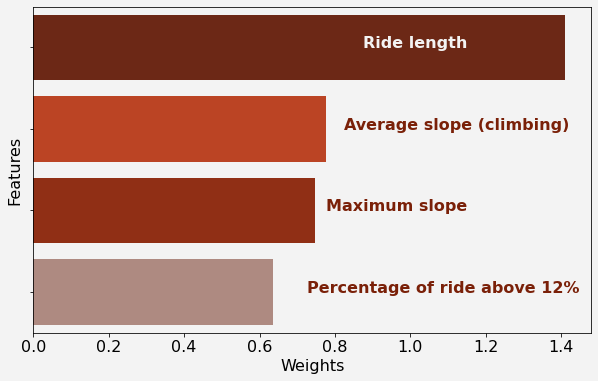

In [305]:
colours = sns.color_palette(['#7a2008', '#d4350b', '#a52300', '#b68679'])
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_coef.sort_values('Weights', ascending=False),
            x='Weights', y='Features', palette=colours)
ax.set_yticklabels(['', '', '', '']);
plt.text(0.875, 0, 'Ride length', c='#f3f3f3', fontweight='bold')
plt.text(0.825, 1, 'Average slope (climbing)', c='#7a2008', fontweight='bold')
plt.text(0.775, 2, 'Maximum slope', c='#7a2008', fontweight='bold')
plt.text(0.725, 3, 'Percentage of ride above 12%', c='#7a2008', fontweight='bold')

Confusion matrix for training on the whole dataset

Text(0.5, 1.0, 'Training Data')

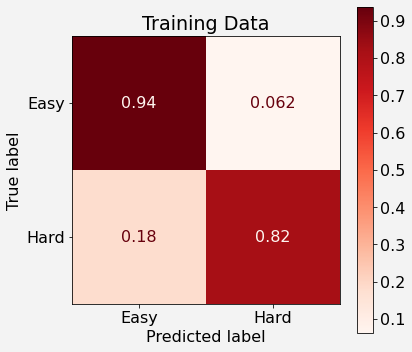

In [270]:
f, ax = plt.subplots(figsize=(6, 6))
sklearn.metrics.plot_confusion_matrix(clf, X_train[cols], y_train,
                                 display_labels=['Easy', 'Hard'],
                                 cmap=plt.cm.Reds,
                                 normalize='true', ax=ax);
plt.title('Training Data')

The False Negative rate is a bit high - almost 20%!  Where does this come from?  Let's look at those class prediction probabilities again.

In [273]:
df = data[cols].copy()
df.set_index(target.index, inplace=True)
df['Probability of Being Hard'] = clf.predict_proba(data[cols])[:, 1]

actual_rating = []
for rte_id, row in df.iterrows():
    rte = int(rte_id[6:])
    if rte in book_ids['easy']:
        actual_rating += ['easy']
    elif rte in book_ids['moderate']:
        actual_rating += ['moderate']
    else:
        actual_rating += ['strenuous']
df['Actual Rating'] = actual_rating
# df.sort_values('Probability Hard', ascending=True)[['Probability Hard', 'actual_rating']]

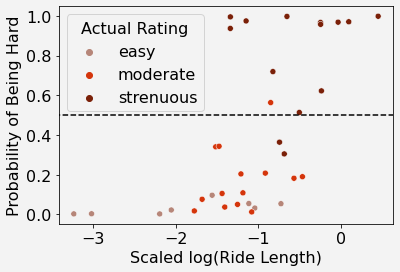

In [277]:
colours = sns.color_palette(['#b68679', '#d4350b', '#7a2008'])
sns.scatterplot(data=df.rename(columns={'dist': 'Scaled log(Ride Length)'}),
                x='Scaled log(Ride Length)', y='Probability of Being Hard', hue='Actual Rating',
               palette=colours)
plt.axhline(0.5, xmin=-3, xmax=2, c='k', linestyle='--');

Interestingly, the two 'strenuous' rides that are hovering around a 30-35% probability of being hard probably do not seem hard enough for good reason!  The book describes both of these as being more suited for hybrid bikes than road bikes, as there are several dirt sections along both routes.  My feature set does not take this into account, so it is unsurpising that it underpredicts the difficulty.

Now save those weights for use in the next step.

In [308]:
config.save_df(feature_coef, config.MODEL_PATH, 'feature_weights.feather')

NOTE: I don't have a good way, other than my intuition, of working out how to weight the road popularity score or the detour score with respect to these difficulty features.  The area covered by the book is somewhat larger, so it would not be a good comparison.  Also, I would imagine that ALL of the routes there should be both pretty popular and very scenic!